# 3.3 로지스틱 회귀를 사용한 클래스 확률 모델링

## 3.3.1 로지스틱 회귀의 이해와 조건부 확률

In [37]:
# 데이터

# 150개의 꽃 샘플에서 꽃잎 길이와 꽃잎 너비를 특성 행렬 X에 할당하고, 이에 상응하는 꽃 품종에 해당하는 클래스 레이블을 벡터 y에 할당한다.

from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2,3]]
y = iris.target
# print('클래스 레이블 :', np.unique(y)) # 클래스 레이블 : [0 1 2]

# 처음 본 데이터에서 훈련된 모델 성능을 평가하기 위해 데이터셋을 훈련 세트와 테스트 세트로 분할한다.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# plot_decision_regions

# plot_decision_regions 함수를 사용하여 새로운 퍼셉트론 모델의 결정 경계를 그려서 세 개의 붓꽃 샘플을 잘 구분하는지 시각화하자.
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    
    # 마커와 컬러맵을 설정한다.
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 결정 경계를 그린다.
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x = X[y == cl, 0],
                    y = X[y == cl, 1],
                    alpha = 0.8, 
                    c = colors[idx], 
                    marker = markers[idx], 
                    label = cl, 
                    edgecolor = 'black')
        
    # 테스트 샘플을 부각하여 그린다.
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        
        plt.scatter(X_test[:, 0], X_test[:, 1],
                    c='', edgecolor='black', alpha=1.0,
                    linewidth=1, marker='o',
                    s=100, label='test set')
        
# 사이킷런의 preprocessing 모듈의 StandardScaler 클래스를 사용하여 특성을 표준화한다.
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

X_combined_std = np.vstack( (X_train_std, X_test_std) )
y_combined = np.hstack( (y_train, y_test) )

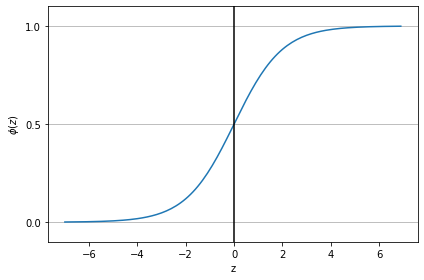

In [38]:
# 시그모이드 함수가 어떤 모습인지 -7 부터 7 까지 그려보자.

import matplotlib.pyplot as plt
import numpy as np

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)
plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')
# y축의 눈금과 격자선
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

## 3.3.2 로지스틱 비용 함수의 가중치 학습

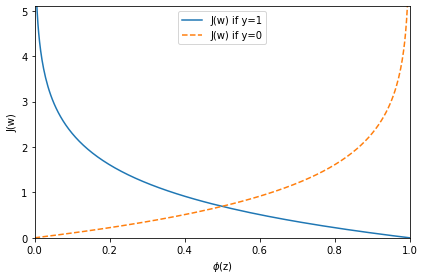

In [39]:
# 샘플이 하나인 경우 phi_z 값에 대한 분류 비용을 그려보자.

def cost_1(z):
    return -np.log(sigmoid(z))

def cost_0(z):
    return -np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)
c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')
c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')
plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## 3.3.3 아달린 구현을 로지스틱 회귀 알고리즘으로 변경

In [40]:
class LogisticRegressionGD(object):
    """경사 하강법을 사용한 로지스틱 회귀 분류기
    
    매개변수
    -----------
    eta : float
        학습률 (0.0과 1.0 사이)
    n_iter : int
        훈련 데이터셋 반복 횟수
    random_state : int
        가중치 무작위 초기화를 위한 난수 생성기 시드
    
    속성
    ----------
    w_ : 1d-array
        학습된 가중치
    cost_ : list
        에포크마다 누적된 로지스틱 비용 함수 값
        
    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        """훈련 데이터 학습
        
        매개변수
        ---------
        X : {array-like}, shape = [n_samples, n_features]
            n_samples개의 샘플과 n_features개의 특성으로 이루어진 훈련 데이터
        y : array-like, shape = [n_samples]
            타깃 값
            
        반환 값
        --------
        self : object
        
        """
        
        rgen= np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1+X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = y - output
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            # 오차 제곱합 대신 로지스틱 비용을 계산한다.
            cost = ( -y.dot(np.log(output)) - ( (1-y).dot( np.log(1 - output) ) ) )
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """최종 입력 계산"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, z):
        """로지스틱 시그모이드 활성화 계산"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def predict(self, X):
        """단위 계단 함수를 사용하여 클래스 레이블을 반환한다."""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        # 다음과 동일하다.
        # return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

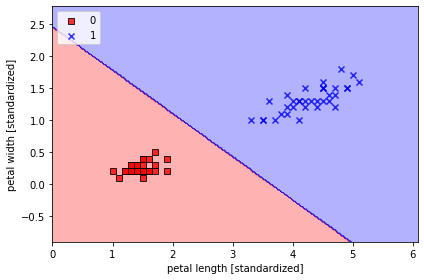

In [41]:
# 여기서 구현한 로지스틱 모델은 이진 분류 문제에만 적용할 수 있다.
# Iris-setosa 와 Iris-versicolor 붓꽃만 가지고 (클래스 0, 1) 로지스틱 회귀 구현이 작동하는지 확인해 보자.

X_train_01_subset = X_train[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta=0.05,
                            n_iter=1000,
                            random_state=1)

lrgd.fit(X_train_01_subset, y_train_01_subset)

plot_decision_regions(X=X_train_01_subset,
                      y=y_train_01_subset,
                      classifier=lrgd)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## 3.3.4 사이킷런을 사용하여 로지스틱 회귀 모델 훈련

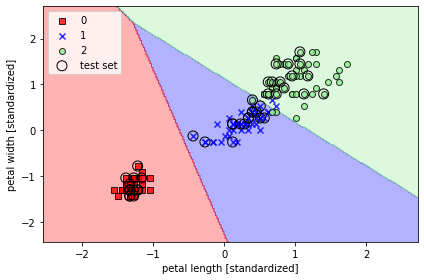

In [42]:
# sklearn.linear_model.LogisticRegression의 fit 메소드를 사용하여 표준화 처리된 붓꽃 데이터셋의 클래스 세개를 대상으로 모델을 훈련한다.
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='liblinear', multi_class='auto', C=100.0, random_state=1)
lr.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=lr, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [46]:
# 훈련 샘플이 어떤 클래스에 속할 확륜은 perdict_proba 메소드를 사용하여 계산한다.
# 예를 들어 테스트 세트에 이쓴 처음 세 개의 샘플 확률은 다음과 같이 예측할 수 있다.
lr.predict_proba(X_test_std[:3, :])

array([[3.17983737e-08, 1.44886616e-01, 8.55113353e-01],
       [8.33962295e-01, 1.66037705e-01, 4.55557009e-12],
       [8.48762934e-01, 1.51237066e-01, 4.63166788e-13]])

In [47]:
# 열을 모두 더하면 1이 된다.
lr.predict_proba(X_test_std[:3, :]).sum(axis=1)

array([1., 1., 1.])

In [48]:
# 행에서 가장 큰 값의 열이 예측 클래스 레이블이 된다. 예를 들어 넘파이 argmax 함수를 사용하면 다음과 같이 쓴다.
lr.predict_proba(X_test_std[:3, :]).argmax(axis=1)

array([2, 0, 0])

In [49]:
# 조건부 확률로부터 얻은 클래스 레이블은 수동적인 방법이다. 직접 predict 메소드를 호출하여 빠르게 확인할 수 있다.
lr.predict(X_test_std[:3, :])

array([2, 0, 0])

In [50]:
# 샘플 하나의 클래스 레이블을 예측할 때 주의할 점이 있는데, 사이킷런은 입력 데이터로 2차원 배열을 기대한다.
# 하나의 행을 먼저 2차원 포맷으로 먼저 변경해야 한다.
# 하나의 행을 2차원 배열로 변환하는 한 가지 방법은 넘파이 reshape 메소드를 사용하여 새로운 차원을 추가하는 것이다.
lr.predict(X_test_std[0, :].reshape(1, -1))

array([2])

## 3.3.5 규제를 사용하여 과대적합 피하기

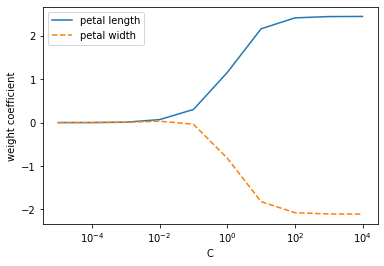

In [53]:
# 두 개의 가중치에 대해서 L2 규제 효과를 그래프로 나타내 보자.

weights, params = [], []

for c in np.arange(-5, 5):
    lr = LogisticRegression(solver='liblinear', multi_class='auto', C=10.**c, random_state=1)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)
    
weights = np.array(weights)
plt.plot(params, weights[:, 0], label='petal length')
plt.plot(params, weights[:, 1], linestyle='--', label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()